## 线性回归

线性回归基于几个简单的假设：首先，假设自变量$𝐱$和因变量$𝑦$之间的关系是线性的，即$𝑦$可以表示为$𝐱$中元素的加权和，这里通常允许包含观测值的一些噪声；其次，我们假设任何噪声都比较正常，如噪声遵循正态分布。

通常使用$n$来表示数据集中的样本数，对索引为i的样本，其输入表示为$\mathbf{x}^{(i)}=\left[x_{1}^{(i)}, x_{2}^{(i)}\right]^{\top}$，对应的标签为$y^{(i)}$。

当我们的输入包含$d$个特征时，我们将预测结果$\hat{y}$（通常使用 “尖角” 符号表示估计值）表示为：

$$
\hat{y}=w_{1} x_{1}+\ldots+w_{d} x_{d}+b
$$

将所有特征放到向量$\mathbf{x} \in \mathbb{R}^{d}$中，并将所有权重放到向量$\mathbf{w} \in \mathbb{R}^{d}$中，我们可以用点积形式来简洁表示模型：

$$
\hat{y}=\mathbf{w}^{\top} \mathbf{x}+b
$$

向量$\mathbf{x}$对应于单个数据样本的特征。用符号表示的矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$可以很方便地引用我们整个数据集的$n$个样本。其中$\mathbf{X}$的每一行是一个样本，每一列是一种特征。

对于特征集合$\mathbf{X}$，预测值$\hat{y} \in \mathbb{R}^{n}$可以通过矩阵-向量乘法表示为：

$$
\hat{\mathbf{y}}=\mathbf{X} \mathbf{w}+b
$$

平方误差可以定义为以下公式：

$$
l^{(i)}(\mathbf{w}, b)=\frac{1}{2}\left(\hat{y}^{(i)}-y^{(i)}\right)^{2}
$$

为了度量模型在整个数据集上的质量，我们需计算在训练集𝑛个样本上的损失均值（也等价于求和）

$$
L(\mathbf{w}, b)=\frac{1}{n} \sum_{i=1}^{n} l^{(i)}(\mathbf{w}, b)=\frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)^{2}
$$

在训练模型的时候，我们希望寻找到一组参数，使得参数能最小化在所有样本上的总损失：

$$
\mathbf{w}^{*}, b^{*}=\underset{\mathbf{w}, b}{\operatorname{argmin}} L(\mathbf{w}, b)
$$

### 显示解

上述问题是有显示解的：$\mathbf{w}^{*}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{y}$

### 小批量随机梯度下降

在整个训练集上算梯度太贵了。一个深度神经网络模型可能需要数分钟至数小时，我们可以随机采样$b$个样本$i_{1}, \dots, i_{b}$来近似损失：

$$
\frac{1}{b} \sum_{i \in I_{b}} \ell\left(\mathbf{x}_{i}, y_{i}, \mathbf{w}\right)
$$

$b$是批量大小，另一个重要的超参数。批量大小太小的话不适用并行来最大利用计算资源，太大的话容易增加内存消耗，浪费计算资源，容易出现重复样本比较多的情况。


1. 初始化模型参数的值，如随机初始化；
2. 从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。


$$
\begin{aligned}
&\mathbf{w} \leftarrow \mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathrm{w}} l^{(i)}(\mathbf{w}, b)=\mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right) \\
&b \leftarrow b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{b} l^{(i)}(\mathbf{w}, b)=b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)
\end{aligned}
$$

## 线性回归的从零开始实现

我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
import sys
sys.path.append("..")
from d2l import torch as d2l

### 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，`features`的每一行是一个长度为2的向量，而`labels`的每一行是一个长度为1的向量（标量）。

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.0695, -1.5259]) 
label: tensor([9.2453])


通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

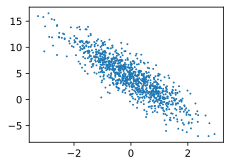

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。



In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0629, -1.0212],
        [-1.5145,  1.1456],
        [-1.4432, -0.5188],
        [-0.5192, -2.0751],
        [-0.6044, -0.8197],
        [ 0.0782,  0.4527],
        [ 0.8054, -0.2353],
        [-0.0253, -0.9917],
        [-0.0326,  1.1501],
        [ 0.1479,  0.7861]]) 
 tensor([[ 5.5426],
        [-2.7402],
        [ 3.0788],
        [10.2249],
        [ 5.7796],
        [ 2.8327],
        [ 6.6220],
        [ 7.5391],
        [ 0.2357],
        [ 1.8260]])


### 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的`requires_grad=True`。

### 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

### 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。


In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。


In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031432
epoch 2, loss 0.000112
epoch 3, loss 0.000049


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。事实上，真实参数和通过训练学到的参数确实非常接近。

In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([2.7359e-04, 6.5088e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0010], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

首先生成数据集

In [13]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [15]:
print(features.shape)
print(labels.shape)

torch.Size([1000, 2])
torch.Size([1000, 1])


### 读取数据集

我们可以调用框架中现有的API来读取数据。我们将 features 和 labels 作为API的参数传递，并在实例化数据迭代器对象时指定 batch_size。此外，布尔值 is_train 表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [17]:
# PyTorch提供了data包来读取数据。
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [18]:
next(iter(data_iter))

[tensor([[-1.1189,  0.9742],
         [-0.5113, -1.0323],
         [ 1.0194, -0.8944],
         [-1.0177,  1.6071],
         [-0.4985,  0.1051],
         [-0.1264,  0.0301],
         [ 1.0710, -0.3531],
         [-1.4332, -0.8651],
         [ 0.5020,  0.3853],
         [-0.2822, -0.7100]]),
 tensor([[-1.3742],
         [ 6.6956],
         [ 9.2820],
         [-3.3178],
         [ 2.8348],
         [ 3.8447],
         [ 7.5569],
         [ 4.2735],
         [ 3.9097],
         [ 6.0492]])]

### 定义模型

在上一节从零开始的实现中，我们需要定义模型参数，并使用它们一步步描述模型是怎样计算的。当模型结构变得更复杂时，这些步骤将变得更繁琐。其实，PyTorch提供了大量预定义的层，这使我们只需关注使用哪些层来构造模型。下面将介绍如何使用PyTorch更简洁地定义线性回归。

首先，导入`torch.nn`模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。之前我们已经用过了`autograd`，而`nn`就是利用`autograd`来定义模型。`nn`的核心数据结构是`Module`，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承`nn.Module`，撰写自己的网络/层。一个`nn.Module`实例应该包含一些层以及返回输出的前向传播（forward）方法。下面先来看看如何用`nn.Module`实现一个线性回归模型。

In [22]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(n_feature = 2)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


事实上我们还可以用`nn.Sequential`来更加方便地搭建网络，`Sequential`是一个有序的容器，网络层将按照在传入`Sequential`的顺序依次被添加到计算图中。
``` python
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])
```
输出：
```
Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)
```

可以通过`net.parameters()`来查看模型所有的可学习参数，此函数将返回一个生成器。
``` python
for param in net.parameters():
    print(param)
```
输出：
```
Parameter containing:
tensor([[-0.0277,  0.2771]], requires_grad=True)
Parameter containing:
tensor([0.3395], requires_grad=True)
```

### 初始化模型参数

在使用net之前，我们需要初始化模型参数。如在线性回归模型中的权重和偏置。 深度学习框架通常有预定义的方法来初始化参数。 在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，偏置参数将初始化为零。

正如我们在构造 nn.Linear 时指定输入和输出尺寸一样。现在我们直接访问参数以设定初始值。我们通过 net[0] 选择网络中的第一个图层，然后使用 weight.data 和 bias.data 方法访问参数。然后使用替换方法 normal_ 和 fill_ 来重写参数值。

In [24]:
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

计算均方误差使用的是MSELoss类，也称为平方$L_{2}$范数。默认情况下，它返回所有样本损失的平均值。

In [25]:
loss = nn.MSELoss()

### 定义优化算法

小批量随机梯度下降算法是一种优化神经网络的标准工具，PyTorch 在 optim 模块中实现了该算法的许多变种。当我们实例化 SGD 实例时，我们要指定优化的参数（可通过 net.parameters() 从我们的模型中获得）以及优化算法所需的超参数字典。小批量随机梯度下降只需要设置 lr值，这里设置为 0.03。

In [26]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练

In [27]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000270
epoch 2, loss 0.000097
epoch 3, loss 0.000096


下面我们比较生成数据集的真实参数和通过有限数据训练获得的模型参数。 要访问参数，我们首先从 net 访问所需的层，然后读取该层的权重和偏置。 正如在从零开始实现中一样，我们估计得到的参数与生成数据的真实参数非常接近。

In [28]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 7.3671e-05, -2.8729e-04])
b的估计误差： tensor([0.0006])


## 问答

1. 为啥使用平方损失而不是绝对差值


平方损失和绝对差值区别不大，不用绝对差值的原因在于绝对值求导不是很方便。


2. 损失为什么要平均

求平均和不求平均本质上是等价的，不求平均的话数值会比较大。间接相当于把学习了扩大了$n$倍：

$$
\mathbf{w}_{t}=\mathbf{w}_{t-1}-\eta \frac{\partial \ell}{\partial \mathbf{w}_{t-1}}
$$

3. 不管是gd还是SGD，怎么找到合适的学习率？有什么好方法吗？


有两个方法，一个是找到一个对学习率不是那么敏感的算法，比如像Adam，第二个是找到一个合适的初始化参数，使得学习率比较小就可以了。

4. batchsize是否会最终影响模型结果？batchsie过小是否可能导致最终累积的梯度计算不准确。


batchsize过小是好的，大了不行。batchsize越小其实是对收敛越好。随机梯度下降理论上是说给你带来了噪音。比如有100万个样本，每次采样两个样本，这样就和真实的分布差距比较大，但是这个噪音对神经网络来说是一个好事情，因为深度神经网络现在都太复杂了，一定的噪音能够使得神经网络不会走偏。

5. 训练过程中，过拟合和欠拟合情况下，学习率和批次该如何进行调整呢？有什么常见的策略吗？

理论上学习率和批次不会影响到最终的结果，但是由于我们无法完全求解，就会有一点影响，但是影响不大。只要不是特别大，一般来说就是多花点时间。

6. 为什么机器学习算法采用一阶导数，而不用牛顿法，收敛速度更快。

二阶导数并不是很好算，一阶导数是向量，二阶导数就是矩阵了。牛顿法收敛很快，但是找到的解可能没有慢慢找的好。

